In [108]:
import numpy as np
import matplotlib.pyplot as plt

In [109]:
N_ITERATIONS = 3600

area_outlet = 1.2272
area_tank = 380.1327

g = 981


In [110]:
def simulate(controller, initial_masses=None, iterations=N_ITERATIONS, gamma1=0.45, gamma2=0.40):
    if initial_masses is None:
        initial_masses = np.zeros(4)

    states = np.empty((iterations + 1, initial_masses.shape[0]))
    states[0] = initial_masses

    flow_rates = np.array([
        gamma1,
        gamma2,
        1 - gamma2,
        1 - gamma1,
    ])

    for t in range(iterations):
        # observe the tank heights in 1 and 2
        observation = states[t, :2] / area_tank
        # pass into controller
        controls = controller(t, observation)

        controls = np.clip(controls, 0, 500)

        pump_force = np.concatenate((controls, controls[::-1]))

        # inflow (pump pipes only)
        inflow = flow_rates * pump_force

        tank_heights = states[t] / area_tank

        outflow = area_outlet * np.sqrt(2 * g * tank_heights)

        # change in tank mass equals inflow minus outflow
        xdot = inflow - outflow
        # but outflow from tanks 3 and 4 land in 1 and 2
        xdot[:2] += outflow[2:]

        states[t + 1] = np.clip(states[t] + xdot, 0, np.inf)

    return states / area_tank

def plot_results(results):

    fig, axes = plt.subplots(2, 2, figsize=(10, 6))

    upper_bound_top_row = np.max(results[:,2:]) * 1.2
    upper_bound_low_row = np.max(results[:,:2]) * 1.2

    order = [2, 3, 0, 1]

    for i, ax in enumerate(axes.flat):
        
        if i in (2 ,3):
            ax.set_xlabel("Time (s)")
        if i in (0, 2):
            ax.set_ylabel("Water level (cm)")

        if i < 2:
            ax.set_ylim(0, upper_bound_top_row)
        else:
            ax.set_ylim(0, upper_bound_low_row)

        i = order[i]
        
        ax.plot(results[:, i])
        ax.set_title(f"Tank {i+1}")
        
        
        ax.grid(True)

    plt.tight_layout()
    plt.show()


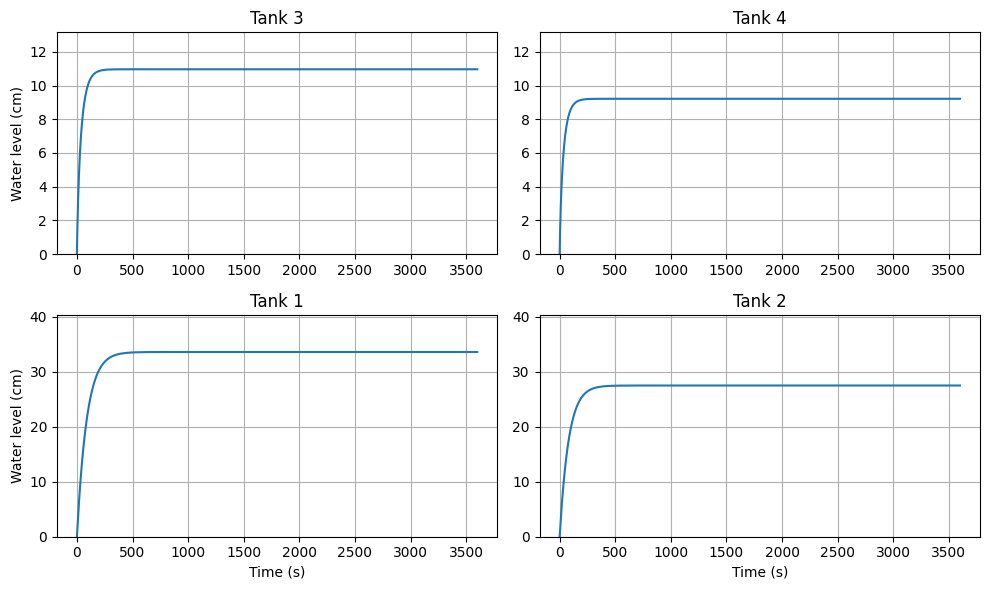

In [111]:
def controls(t, state):
    return np.ones(2) * 300

results = simulate(controls)

plot_results(results)

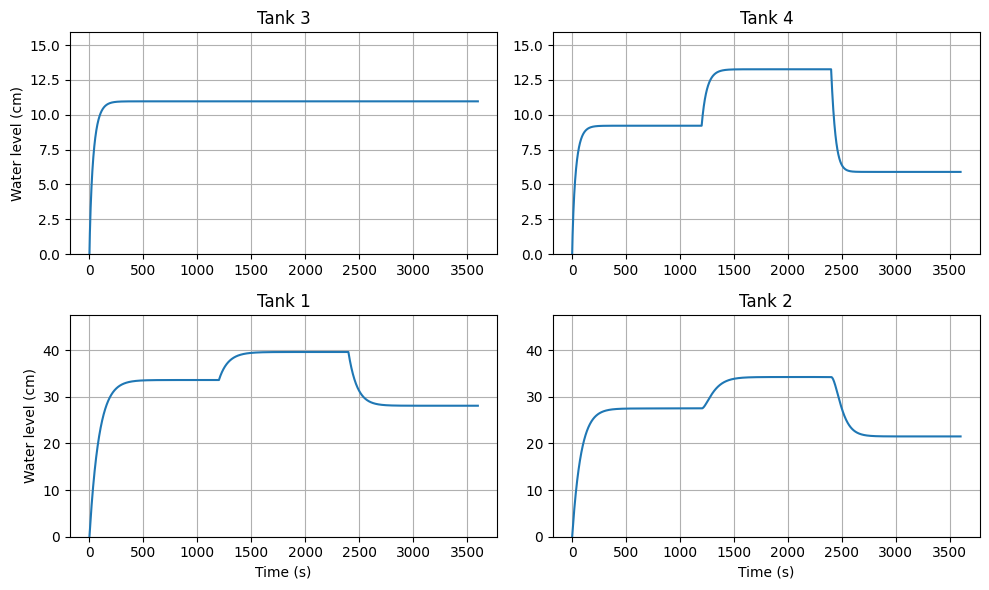

In [112]:
def controls(t, state):
    if t < 1200:
        u1 = 300
    elif t < 2400:
        u1 = 360
    else:
        u1 = 240
    return np.array([u1, 300])

results = simulate(controls)

plot_results(results)

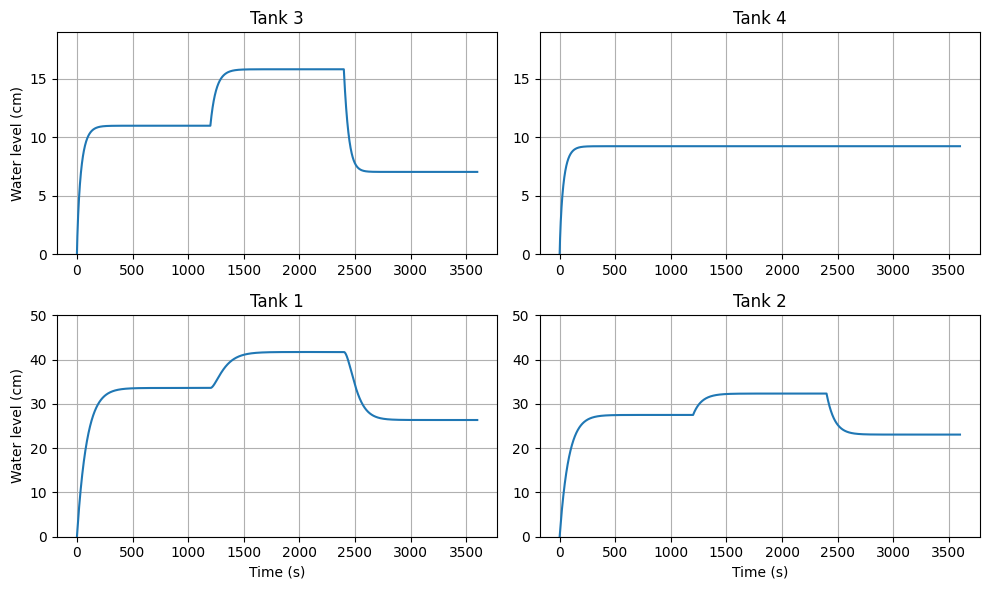

In [113]:
def controls(t, state):
    if t < 1200:
        u2 = 300
    elif t < 2400:
        u2 = 360
    else:
        u2 = 240
    return np.array([300, u2])
results = simulate(controls)

plot_results(results)

In [114]:
class PIDController:
    def __init__(self, target, p=0, i=0, d=0):
        self.target = target
        
        self.p = p
        self.i = i
        self.d = d

        self.prev = None
        self.int = np.zeros(2)

    def __call__(self, observation):

        error = self.target - observation

        p = self.p * error

        self.int += error
        i = self.i * self.int

        if self.prev is not None:
            d = self.d * (error - self.prev)
        else:
            d = np.zeros(2)

        self.prev = error

        return p + i + d



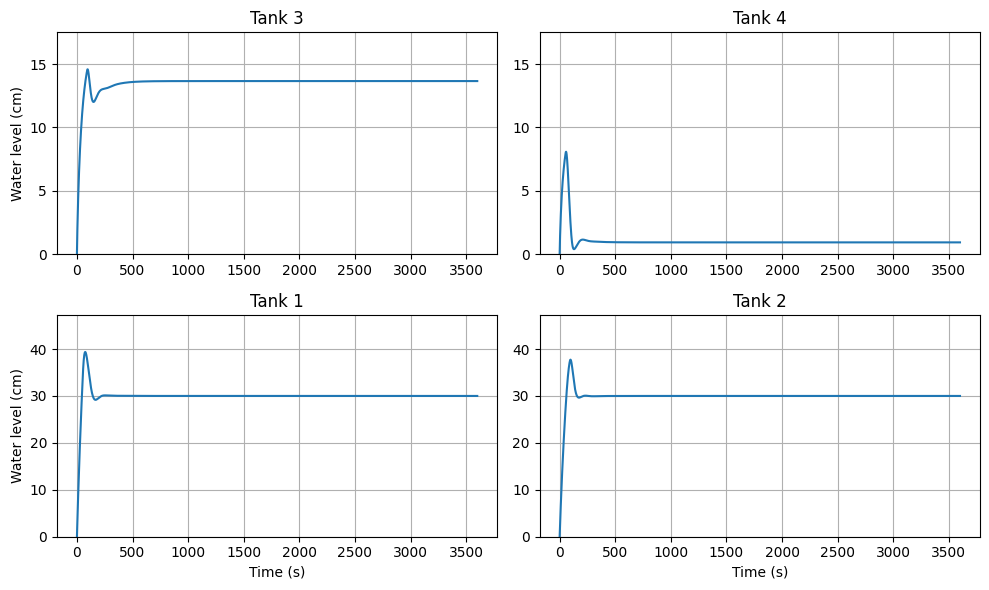

In [115]:
pid = PIDController(np.array([30.0, 30.0]), p=25, i=1.0)

def controls(t, observation):    
    control = pid(observation)
    return control

results = simulate(controls, gamma1=0.65, gamma2=0.55)
plot_results(results)

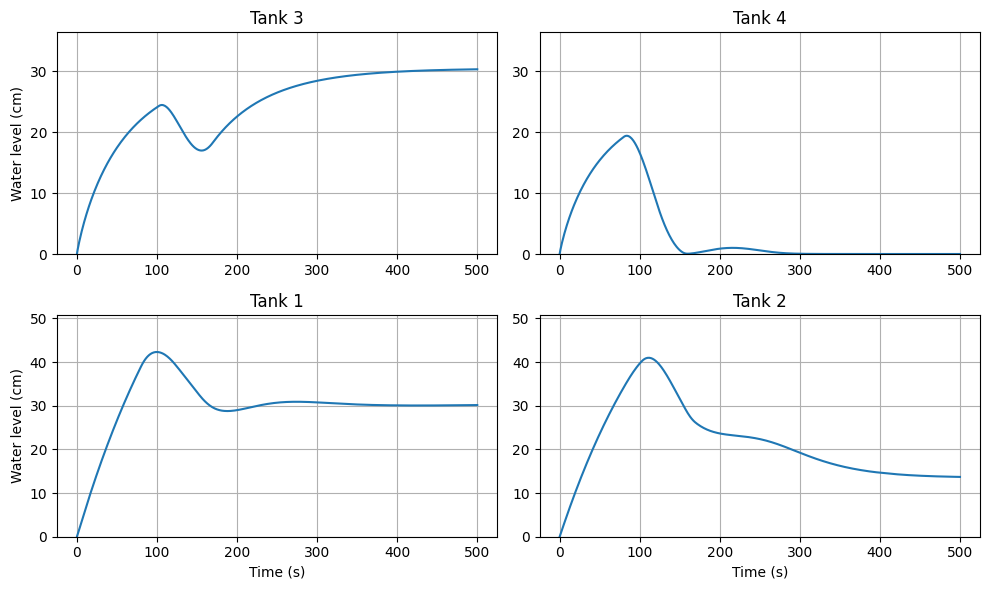

In [ ]:
pid = PIDController(np.array([30.0, 30.0]), p=25, i=1.0)

def controls(t, observation):    
    control = pid(observation)
    return control

results = simulate(controls, gamma1=0.45, gamma2=0.40)
plot_results(results)